# Baseline CNN for Gravitational Lensing Classification

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Data location and a sneak peek

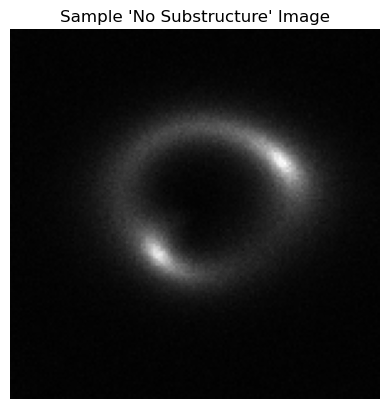

In [2]:
base_dir = r"/mnt/Data/GSoC25/ML4SCI/Evaluation Task/data/dataset/dataset"

# Quick look at one image
sample_path = os.path.join(base_dir, "train", "no", os.listdir(os.path.join(base_dir, "train", "no"))[0])
img = np.load(sample_path).squeeze(0)
plt.imshow(img, cmap='gray')
plt.title("Sample 'No Substructure' Image")
plt.axis('off')
plt.show()

### Loading Dataset

The dataset’s pre-split into `train` (30,000 files) and `val` (7,500 files)—an 80:20 split. The guideline says 90:10, but I think it might be a mistake, so I am sticking with the provided split.

In [3]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.data = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.data.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = np.load(img_path).squeeze(0)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        return img, label

### The Baseline Model

Using Pre-trained ResNet18.

In [4]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 3)

    def forward(self, x):
        return self.resnet(x)

### Training Function

Simple crossEntropy loss

In [5]:
def train_model(model, train_loader, val_loader, epochs=50, device=device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    best_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        auc_score = roc_auc_score(val_labels, val_preds, multi_class='ovr')
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, AUC: {auc_score:.4f}')

        if auc_score > best_auc:
            best_auc = auc_score
            torch.save(model.state_dict(), 'BaselineCNN_Weights.pth')

### Evaluation Function

In [6]:
def evaluate_model(model, val_loader, device=device):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_preds = np.concatenate(test_preds)
    test_labels = np.concatenate(test_labels)

    fpr, tpr, roc_auc = {}, {}, {}
    class_names = ['No Substructure', 'Subhalo', 'Vortex']
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - BaselineCNN')
    plt.legend()
    plt.show()

    print("AUC Scores:", roc_auc)

### Setting up and Running

Kicking off BaselineCNN training...
Epoch 1, Loss: 1.0903, AUC: 0.6711
Epoch 2, Loss: 0.8818, AUC: 0.8433
Epoch 3, Loss: 0.6418, AUC: 0.9238
Epoch 4, Loss: 0.5113, AUC: 0.9518
Epoch 5, Loss: 0.4334, AUC: 0.9592
Epoch 6, Loss: 0.3899, AUC: 0.9705
Epoch 7, Loss: 0.3471, AUC: 0.9674
Epoch 8, Loss: 0.3213, AUC: 0.9751
Epoch 9, Loss: 0.2984, AUC: 0.9754
Epoch 10, Loss: 0.2703, AUC: 0.9787
Epoch 11, Loss: 0.2559, AUC: 0.9789
Epoch 12, Loss: 0.2446, AUC: 0.9773
Epoch 13, Loss: 0.2299, AUC: 0.9805
Epoch 14, Loss: 0.2135, AUC: 0.9816
Epoch 15, Loss: 0.1986, AUC: 0.9834
Epoch 16, Loss: 0.1879, AUC: 0.9827
Epoch 17, Loss: 0.1873, AUC: 0.9848
Epoch 18, Loss: 0.1721, AUC: 0.9851
Epoch 19, Loss: 0.1648, AUC: 0.9821
Epoch 20, Loss: 0.1602, AUC: 0.9856
Epoch 21, Loss: 0.1529, AUC: 0.9812
Epoch 22, Loss: 0.1474, AUC: 0.9767
Epoch 23, Loss: 0.1409, AUC: 0.9875
Epoch 24, Loss: 0.1357, AUC: 0.9641
Epoch 25, Loss: 0.1321, AUC: 0.9866
Epoch 26, Loss: 0.1262, AUC: 0.9858
Epoch 27, Loss: 0.1241, AUC: 0.9864
E

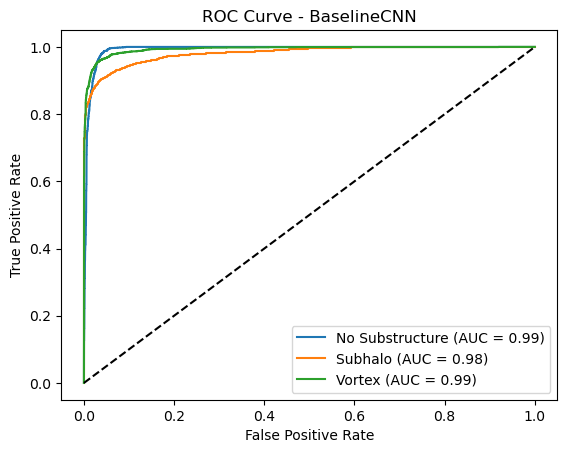

AUC Scores: {0: 0.99256876, 1: 0.98098312, 2: 0.9933272400000001}


In [9]:
transform = transforms.Compose([transforms.RandomRotation(10)])

train_dataset = LensingDataset(base_dir, split='train', transform=transform)
val_dataset = LensingDataset(base_dir, split='val')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

torch.cuda.empty_cache()
cnn = BaselineCNN().to(device)
print("Kicking off BaselineCNN training...")
train_model(cnn, train_loader, val_loader, epochs=50)
cnn.load_state_dict(torch.load('BaselineCNN_Weights.pth'))
evaluate_model(cnn, val_loader)